In this exercise, we build on the previous exercises to prepare a labeled dataset of binary feature vectors, and use it to train a *Random Forest* binary classifier of malware/benign feature vectors.

In [3]:
import os
directoriesWithLabels = [("RandomSamples/Benign",0), ("RandomSamples/Malware",1)]
listOfSamples = []
labels = []
for datasetPath, label in directoriesWithLabels:
    samples = [f for f in os.listdir(datasetPath)]
    for file in samples:
        filePath = os.path.join(datasetPath, file)
        listOfSamples.append(filePath)
        labels.append(label)

In [1]:
!git clone https://github.com/iosifache/DikeDataset.git
import shutil
import os

# Define source directory and destination directory for benign files
source_benign_directory = '/content/DikeDataset/files/benign'
destination_benign_directory = '/content/RandomSamples/Benign'

# Create destination directory for benign files if it doesn't exist
# if not os.path.exists(destination_benign_directory):
#     os.makedirs(destination_benign_directory)

# Get the list of files in the source directory for benign files
benign_files = os.listdir(source_benign_directory)

# Iterate through the first 100 files in the benign files list and copy them to the destination directory
for filename in benign_files[:100]:
    source_file = os.path.join(source_benign_directory, filename)
    destination_file = os.path.join(destination_benign_directory, filename)
    shutil.copyfile(source_file, destination_file)

# Define source directory and destination directory for malware files
source_malware_directory = '/content/DikeDataset/files/malware'
destination_malware_directory = '/content/RandomSamples/Malware'

# Create destination directory for malware files if it doesn't exist
# if not os.path.exists(destination_malware_directory):
#     os.makedirs(destination_malware_directory)

# Get the list of files in the source directory for malware files
malware_files = os.listdir(source_malware_directory)

# Iterate through the first 100 files in the malware files list and copy them to the destination directory
for filename in malware_files[:100]:
    source_file = os.path.join(source_malware_directory, filename)
    destination_file = os.path.join(destination_malware_directory, filename)
    shutil.copyfile(source_file, destination_file)


Cloning into 'DikeDataset'...
remote: Enumerating objects: 11989, done.
remote: Counting objects: 100% (11989/11989), done.
remote: Compressing objects: 100% (9243/9243), done.
remote: Total 11989 (delta 2749), reused 11981 (delta 2741), pack-reused 0
Receiving objects: 100% (11989/11989), 2.38 GiB | 34.60 MiB/s, done.
Resolving deltas: 100% (2749/2749), done.
Updating files: 100% (11936/11936), done.


In [7]:
!pip install nltk pefile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 738.8 kB/s eta 0:00:00


In [8]:
import collections
from nltk import ngrams
import numpy as np
import pefile

def readFile(filePath):
    with open(filePath, "rb") as binary_file:
        data = binary_file.read()
    return data

def byteSequenceToNgrams(byteSequence, n):
    Ngrams = ngrams(byteSequence, n)
    return list(Ngrams)

def extractNgramCounts(file, N):
    fileByteSequence = readFile(file)
    fileNgrams = byteSequenceToNgrams(fileByteSequence, N)
    return collections.Counter(fileNgrams)

def getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list):
    K1 = len(K1_most_common_Ngrams_list)
    fv = K1*[0]
    fileNgrams = extractNgramCounts(file, N)
    for i in range(K1):
        fv[i]=fileNgrams[K1_most_common_Ngrams_list[i]]
    return fv

def preprocessImports(listOfDLLs):
    processedListOfDLLs = []
    temp = [x.decode().split(".")[0].lower() for x in listOfDLLs]
    return " ".join(temp)

def getImports(pe):
    listOfImports = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        listOfImports.append(entry.dll)
    return preprocessImports(listOfImports)

def getSectionNames(pe):
    listOfSectionNames = []
    for eachSection in pe.sections:
        refined_name = eachSection.Name.decode().replace('\x00','').lower()
        listOfSectionNames.append(refined_name)
    return " ".join(listOfSectionNames)

In [9]:
# Generate 2-Grams,
# and produce feature vectors based on the frequency method
# This may take a few minutes to run
N=2
totalNgramCount = collections.Counter([])
for file in samples_train:
    totalNgramCount += extractNgramCounts(file, N)
K1 = 100
K1_most_common_Ngrams = totalNgramCount.most_common(K1)
K1_most_common_Ngrams_list = [x[0] for x in K1_most_common_Ngrams]

In [10]:
# Extract N-gram features based on the frequency method
# Also, extracts some metadata such as DLL imports,
# and PE Sections. We will combine these with
# our N-gram features to enrich the sample representation.
# This will take a few minutes to run.
# Some samples will generate errors such as 'not a PE file',
# 'DOS header not found', and 'invalid attribute'. These are OK.
importsCorpus_train = []
numSections_train = []
sectionNames_train = []
NgramFeaturesList_train = []
y_train = []
for i in range(len(samples_train)):
    file = samples_train[i]
    try:
        NGramFeatures = getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list)
        pe = pefile.PE(file)
        imports = getImports(pe)
        nSections = len(pe.sections)
        secNames = getSectionNames(pe)
        importsCorpus_train.append(imports)
        numSections_train.append(nSections)
        sectionNames_train.append(secNames)
        NgramFeaturesList_train.append(NGramFeatures)
        y_train.append(labels_train[i])
    except Exception as e:
        print(file+":")
        print(e)

RandomSamples/Benign/daf40d9a2ec0f85748aa446e41c11cf7188fdfa0f00d84652a38699c5e04863a.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
RandomSamples/Benign/a6266f82f8549582c1ede57f127c9f65e2f7271c42b7ed51f0fef0f0eb2bb90e.ole:
'DOS Header magic not found.'
RandomSamples/Benign/1e83c1a2f6f2b7080c7fefccff1fde4bb14aa8a57e851817c92a6f1c946ca17a.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
RandomSamples/Benign/6a5a9543efdcbfea2f59591f16302e200dbcc4966c7642aabc9be79910d7855a.ole:
'DOS Header magic not found.'
RandomSamples/Malware/6489603b61e93998d4f76eb05db075cdd7001a17873ca26b83869880a12aa4fd.ole:
'DOS Header magic not found.'
RandomSamples/Malware/eca134d5ba493b631f1961738e4af190b9ffcb430fde25940e77c2ce91dc6815.ole:
'DOS Header magic not found.'
RandomSamples/Malware/919338befb7b39e71d750fdf3328dbaf4194b881a93e016583026c733e5176a5.ole:
'DOS Header magic not found.'
RandomSamples/Benign/76fe3c60788550dde172e3722a624f1407890e3cc39895f9dc233d0e0cc5e566.ole:
'DOS Header

In the following lines, we define a pipeline of sequential transforms (HashingVectorizer and TfidfTransformer) to extract N-gram featurs and construct feature vectors from the DLL imports and Section names extracted for each sample.

In [12]:
# Combine the binary N-gram features with
# the DLL imports and section names features to create
# vectorized training samples
from scipy.sparse import hstack, csr_matrix
X_train = hstack([NgramFeaturesList_train, importsCorpus_train_transformed,sectionNames_train_transformed, csr_matrix(numSections_train).transpose()])

In [14]:
importsCorpus_test_transformed = imports_featurizer.transform(importsCorpus_test)
sectionNames_test_transformed = section_names_featurizer.transform(sectionNames_test)
X_test = hstack([NgramFeaturesList_test, importsCorpus_test_transformed,sectionNames_test_transformed, csr_matrix(numSections_test).transpose()])

In [22]:
import joblib
clf = joblib.load("model.joblib")

In [32]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The nltk version is 3.8.1.
The scikit-learn version is 1.2.2.


In [35]:
#Train-Test data split
from sklearn.model_selection import train_test_split
samples_train, samples_test, labels_train, labels_test = train_test_split(listOfSamples, labels, test_size=0.99, stratify=labels, random_state=42)

In [36]:
import collections
from nltk import ngrams
import numpy as np
import pefile

def readFile(filePath):
    with open(filePath, "rb") as binary_file:
        data = binary_file.read()
    return data

def byteSequenceToNgrams(byteSequence, n):
    Ngrams = ngrams(byteSequence, n)
    return list(Ngrams)

def extractNgramCounts(file, N):
    fileByteSequence = readFile(file)
    fileNgrams = byteSequenceToNgrams(fileByteSequence, N)
    return collections.Counter(fileNgrams)

def getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list):
    K1 = len(K1_most_common_Ngrams_list)
    fv = K1*[0]
    fileNgrams = extractNgramCounts(file, N)
    for i in range(K1):
        fv[i]=fileNgrams[K1_most_common_Ngrams_list[i]]
    return fv

def preprocessImports(listOfDLLs):
    processedListOfDLLs = []
    temp = [x.decode().split(".")[0].lower() for x in listOfDLLs]
    return " ".join(temp)

def getImports(pe):
    listOfImports = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        listOfImports.append(entry.dll)
    return preprocessImports(listOfImports)

def getSectionNames(pe):
    listOfSectionNames = []
    for eachSection in pe.sections:
        refined_name = eachSection.Name.decode().replace('\x00','').lower()
        listOfSectionNames.append(refined_name)
    return " ".join(listOfSectionNames)

In [37]:
# Generate feature vectors for the test samples
# This may take a few minutes
importsCorpus_test = []
numSections_test = []
sectionNames_test = []
NgramFeaturesList_test = []
y_test = []
for i in range(len(samples_test)):
    file = samples_test[i]
    try:
        NGramFeatures = getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list)
        pe = pefile.PE(file)
        imports = getImports(pe)
        nSections = len(pe.sections)
        secNames = getSectionNames(pe)
        importsCorpus_test.append(imports)
        numSections_test.append(nSections)
        sectionNames_test.append(secNames)
        NgramFeaturesList_test.append(NGramFeatures)
        y_test.append(labels_test[i])
    except Exception as e:
        print(file+":")
        print(e)

RandomSamples/Malware/a2c2b9c47e3b328406635f213d4a7ed2ce9a131342defd6e84cdd385cfb1845f.ole:
'DOS Header magic not found.'
RandomSamples/Benign/1302667485bd8b4dfcb5cc273cd05da1ca61927b5e923a5acbc2aaa1829ecfa1.exe:
'Invalid NT Headers signature. Probably a NE file'
RandomSamples/Malware/6304d9157e443c349a212dcf8c2ee4bf23645a1f690a499ac31bed22e2995f6b.ole:
'DOS Header magic not found.'
RandomSamples/Benign/978ef8171f02b8ac7b85736f1f75af94da2e41dc8ced6809641dad0bbb1a0d0a.ole:
'DOS Header magic not found.'
RandomSamples/Benign/51ee81dbc0add93b11aa0d4ad02308243c1c194b4bed94722cb18bcf8f2836cf.exe:
'DOS Header magic not found.'
RandomSamples/Malware/919338befb7b39e71d750fdf3328dbaf4194b881a93e016583026c733e5176a5.ole:
'DOS Header magic not found.'
RandomSamples/Benign/621c3430af290e8ed10683d645961c1a047b3eb8521645853a26176597f38760.ole:
'DOS Header magic not found.'
RandomSamples/Malware/6489603b61e93998d4f76eb05db075cdd7001a17873ca26b83869880a12aa4fd.ole:
'DOS Header magic not found.'
RandomS

In [38]:
importsCorpus_test_transformed = imports_featurizer.transform(importsCorpus_test)
sectionNames_test_transformed = section_names_featurizer.transform(sectionNames_test)
X_test = hstack([NgramFeaturesList_test, importsCorpus_test_transformed,sectionNames_test_transformed, csr_matrix(numSections_test).transpose()])

In [39]:
clf.score(X_test, y_test)

0.9875

In [40]:
from sklearn.metrics import accuracy_score
y_predict = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy:', accuracy)

Accuracy: 0.9875


In [43]:
# Test accuracy
test_accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9875


In [44]:
# Recall
recall = recall_score(y_test, clf.predict(X_test))
print("Recall:", recall)

Recall: 0.974025974025974


In [45]:
# F1 score
f1 = f1_score(y_test, clf.predict(X_test))
print("F1 Score:", f1)

F1 Score: 0.9868421052631579


Confusion Matrix:
 [[83  0]
 [ 2 75]]


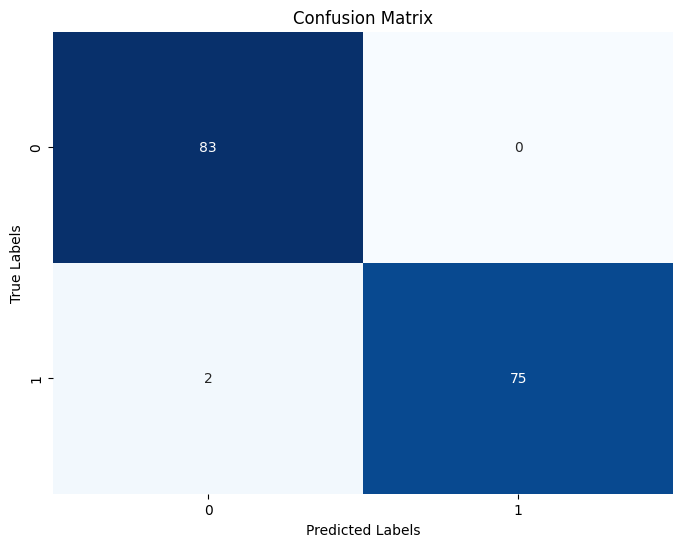

In [46]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()